In [1]:
import numpy as np
import json
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv
import cv2
import time
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


def readFiles(directory):
    df = []
    for filename in os.listdir(directory):
        file = os.path.join(directory, filename)
        data = json.load(open(file))
        #numpy_2d_arrays = np.array(data)
        #df.append(numpy_2d_arrays)
        df.append(data)
    return df



df = readFiles('./jsons/')
print(df[0])

2022-08-12 10:45:20.495377: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-12 10:45:20.495414: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


{'dataset': 'pig-processing', 'image': [{'width': 512, 'height': 512, 'original_filename': 'C8 - 2HR9kY_6420.jpg', 'filename': 'C8 - 2HR9kY_6420.jpg', 'url': 'https://darwin.v7labs.com/api/v2/teams/pig-image-processing/files/0012e1bb-123b-46c0-b20a-69065dcb221d/original', 'thumbnail_url': 'https://darwin.v7labs.com/api/v2/teams/pig-image-processing/files/0012e1bb-123b-46c0-b20a-69065dcb221d/thumbnail', 'path': '/', 'workview_url': 'https://darwin.v7labs.com/teams/pig-image-processing/items/0182156d-74b0-d107-49b9-996a293ea7cb/workview'}], 'annotations': [{'bounding_box': {'h': 247.0, 'w': 269.0, 'x': 168.0, 'y': 151.0}, 'id': '46a8bd50-79d3-4a53-8cad-7af24e292283', 'name': 'pig', 'polygon': {'path': [{'x': 195.0, 'y': 153.0}, {'x': 194.0, 'y': 154.0}, {'x': 194.0, 'y': 156.0}, {'x': 190.0, 'y': 159.0}, {'x': 189.0, 'y': 159.0}, {'x': 189.0, 'y': 162.0}, {'x': 188.0, 'y': 163.0}, {'x': 188.0, 'y': 166.0}, {'x': 187.0, 'y': 167.0}, {'x': 187.0, 'y': 172.0}, {'x': 185.0, 'y': 175.0}, {'x'

In [2]:
#First version with polygon in it, in case of future uses
data_arr = []
for index in range(len(df)):
    try:
        filename = df[index].get("image")[0].get("filename")
        width = df[index].get("image")[0].get("width")
        height = df[index].get("image")[0].get("height")
        bbox = df[index].get("annotations")[0].get("bounding_box")
        polygon = df[index].get("annotations")[0].get("polygon").get("path")
        class_name = weight = df[index].get("annotations")[0].get("name")
        weight = df[index].get("annotations")[0].get("text").get("text")
        data_arr.append([filename, width, height, class_name, weight, bbox, polygon])
    except:
        print("Error with file: " + filename)




In [53]:
#Second version used for Keras RetinaNet
data_arr = []
for index in range(len(df)):
    try:
        filename = "dataset_resized_final/"+df[index].get("image")[0].get("filename")
        bbox = df[index].get("annotations")[0].get("bounding_box")
        box = [int(bbox["x"]), int(bbox["y"]), int(bbox["w"]), int(bbox["h"])]
        x1 = int(box[0])
        y1 = int(box[1])
        x2 = int(box[0])+int(box[2])
        y2 = int(box[1])+int(box[3])
        class_name = weight = df[index].get("annotations")[0].get("name")
        weight = df[index].get("annotations")[0].get("text").get("text")
        data_arr.append([filename, x1, y1, x2, y2, str(class_name+": "+weight)])
    except:
        print("Error with file: " + filename)


In [54]:
print(data_arr[0])

['dataset_resized_final/C8 - 2HR9kY_6420.jpg', 168, 151, 437, 398, 'pig: 80.0']


In [5]:
#Version 1 for the data_arr that contains a polygon.
def show_image_objects(imagerow):
    img_path = str("dataset_resized_final/"+imagerow[0])
    print(img_path)
    box = [int(imagerow[5]["x"]), int(imagerow[5]["y"]), int(imagerow[5]["w"]), int(imagerow[5]["h"])]
    print(box)
    image = im = cv2.imread(""+img_path)
    
    start_point = (int(box[0]), int(box[1]))
    end_point = (int(box[0])+int(box[2]), int(box[1])+int(box[3]))

    color = (72, 139, 194)
    linethickness = 2
    image = cv2.rectangle(image, start_point, end_point, color, linethickness)
    
    cv2.imshow('Image', image)
    cv2.waitKey(5000)

In [58]:
#Version 2 for the data that has x1,y1,x2,y2
def show_image_objects_retinanet(imagerow):
    img_path = imagerow[0]
    box = [
        imagerow[1], imagerow[2], imagerow[3], imagerow[4]
    ]

    image = read_image_bgr(img_path)

    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    draw_box(draw, box, color=(255, 255, 0))

    plt.axis('off')
    plt.imshow(draw)
    plt.show()

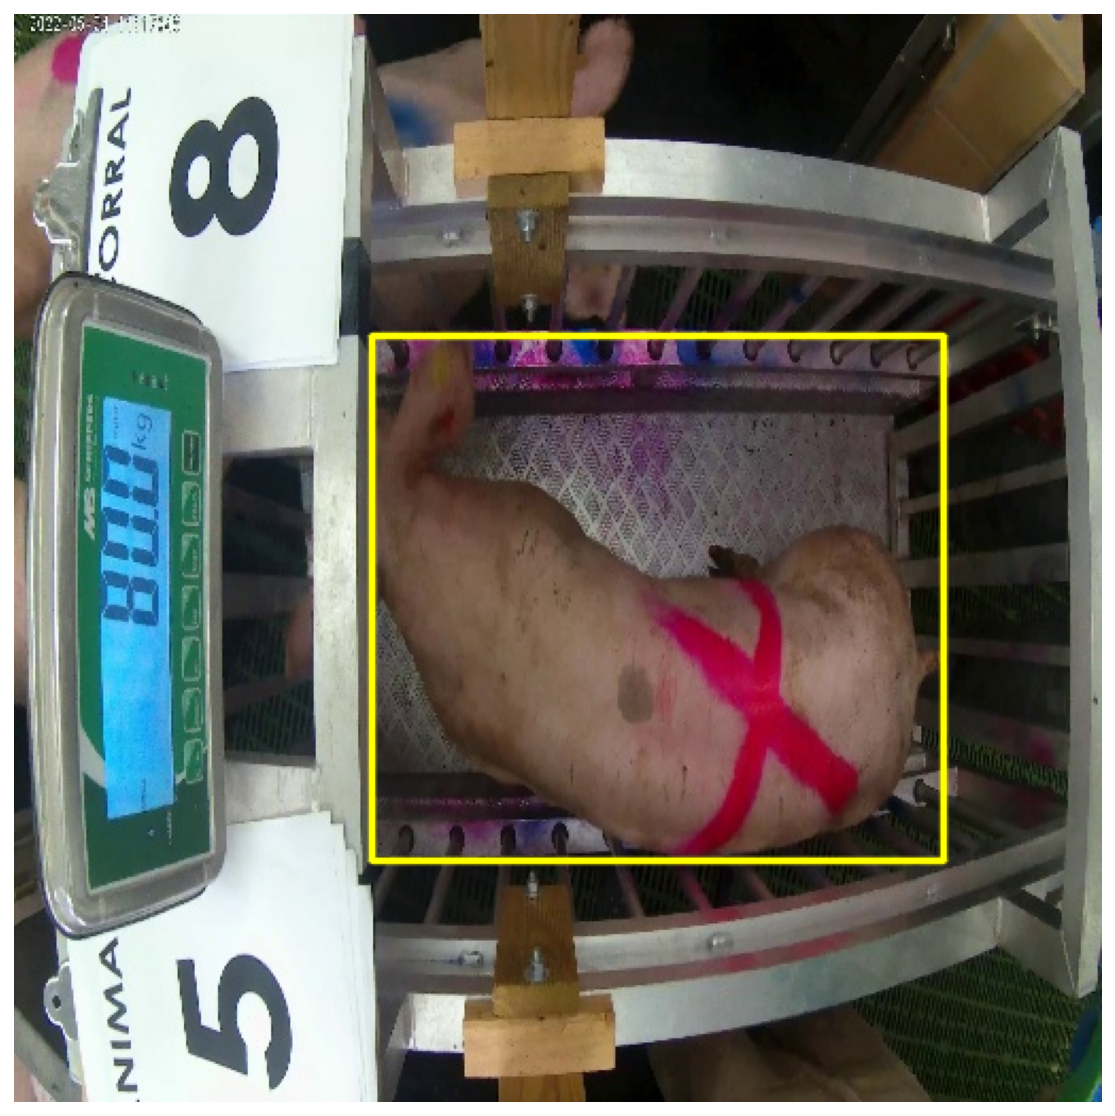

In [59]:
show_image_objects_retinanet(data_arr[0])

In [62]:
train_df, test_df = train_test_split(
  data_arr, 
  test_size=0.2, 
  random_state=RANDOM_SEED
)

ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

with open(ANNOTATIONS_FILE, 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(np.array(train_df))

    
classes_arr = []
for idx in range(len(data_arr)):
    classes_arr.append(data_arr[idx][5])
    
classes = sorted(set(classes_arr))
print(classes)

with open(CLASSES_FILE, 'w') as f:
    for i, line in enumerate(sorted(classes)):
        f.write('{},{}\n'.format(line,i))

!head classes.csv

['pig: 100.0', 'pig: 100.5', 'pig: 101.0', 'pig: 101.5', 'pig: 102.0', 'pig: 102.5', 'pig: 103.0', 'pig: 103.5', 'pig: 104.0', 'pig: 104.5', 'pig: 105.0', 'pig: 105.5', 'pig: 105.5\n', 'pig: 106.0', 'pig: 106.5', 'pig: 107.0', 'pig: 107.5', 'pig: 108.0', 'pig: 108.5', 'pig: 109.0', 'pig: 109.5', 'pig: 110.0', 'pig: 110.5', 'pig: 111.0', 'pig: 111.5', 'pig: 112.0', 'pig: 112.5', 'pig: 113.0', 'pig: 113.5', 'pig: 114.0', 'pig: 114.5', 'pig: 115.0', 'pig: 115.5', 'pig: 116.0', 'pig: 116.5', 'pig: 117.0', 'pig: 117.5', 'pig: 118.0', 'pig: 118.5', 'pig: 119.0', 'pig: 119.5', 'pig: 120.0', 'pig: 120.5', 'pig: 121.0', 'pig: 121.5', 'pig: 122.0', 'pig: 122.5', 'pig: 123.0', 'pig: 123.5', 'pig: 124.0', 'pig: 125.0', 'pig: 125.5', 'pig: 126.0', 'pig: 126.5', 'pig: 127.0', 'pig: 127.5', 'pig: 128.0', 'pig: 21.5', 'pig: 22.0', 'pig: 22.5', 'pig: 23.0', 'pig: 24.0', 'pig: 25.5', 'pig: 26.0', 'pig: 26.5', 'pig: 27.0', 'pig: 27.5', 'pig: 28.0', 'pig: 28.5', 'pig: 29.0', 'pig: 29.5', 'pig: 30.0', 'pig

In [63]:
!head annotations.csv

In [30]:
%cd keras-retinanet

/home/catalin/python-projects/PigsImageProcessing/neural_network/keras-retinanet


In [64]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


In [73]:
!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 8 --steps 500 --epochs 10 csv annotations.csv classes.csv

2022-08-12 11:56:31.741930: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/catalin/envs/PigsAIEnv/lib/python3.8/site-packages/cv2/../../lib64:
2022-08-12 11:56:31.741992: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Creating model, this may take a second...
2022-08-12 11:57:10.647563: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/catalin/envs/PigsAIEnv/lib/python3.8/site-packages/cv2/../../lib64:/home/catalin/envs/PigsAIEnv/lib/python3.8/site-packages/cv2/../../lib64:
2022-08-12 11:57:10.647607: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call

keras_retinanet/bin/train.py:538: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  return training_model.fit_generator(
Epoch 1/10


In [ ]:
######################## Need to try this out after training is done.
!ls snapshots
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)

model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

labels_to_names = pd.read_csv(CLASSES_FILE, header=None).T.loc[0].to_dict()

In [ ]:
def predict(image):
    image = preprocess_image(image.copy())
    image, scale = resize_image(image)

    boxes, scores, labels = model.predict_on_batch(
        np.expand_dims(image, axis=0)
    )

    boxes /= scale

    return boxes, scores, labels

In [ ]:
THRES_SCORE = 0.6

def draw_detections(image, boxes, scores, labels):
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < THRES_SCORE:
            break

    color = label_color(label)

    b = box.astype(int)
    draw_box(image, b, color=color)

    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(image, b, caption)

In [ ]:
def show_detected_objects(image_row):
    img_path = image_row.image_name

    image = read_image_bgr(img_path)

    boxes, scores, labels = predict(image)

    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    true_box = [
        image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
    ]
    draw_box(draw, true_box, color=(255, 255, 0))

    draw_detections(draw, boxes, scores, labels)

    plt.axis('off')
    plt.imshow(draw)
    plt.show()

In [ ]:
test_df.head(n=10)

In [ ]:
show_detected_objects(test_df[0])

In [ ]:
show_detected_objects(test_df[1])